In [3]:
import os 
import numpy as np
import cv2
from matplotlib import pyplot as plt
import filecmp

In [4]:
#Handling missing files and taking the common files in both the directories

In [5]:
#path with all the images
def read_images(path):
    image_labels = [] 
    image_names = sorted(os.listdir(path))
    for imgs in image_names:     #imgs -> iteration variable -> name of the images
        image = cv2.imread(os.path.join(path,imgs))
        image_labels.append(image)
        
    image_labels = np.array(image_labels)
    return image_labels

In [6]:
def read_common_images(path,image_names):
    images =[]
    for img in image_names:
        image = cv2.imread(os.path.join(path,img))
        images.append(image)
    images = np.array(images)
    return images

In [7]:
dir1 = '/home/aleti/Desktop/Optical disc/OD-Labeled-20200810T160226Z-001/OD-Labeled/'
dir2 = '/home/aleti/Desktop/Optical disc/OD-ALL/OD-Full-20201230T050531Z-001/OD-Full/'

In [8]:
result = filecmp.dircmp(dir1,dir2)

In [9]:
image_names = result.common

In [10]:
images = read_common_images(dir1,image_names)

In [11]:
unlabeled = read_common_images(dir2,image_names)

In [12]:
cv2.imshow('img',images[10])
cv2.imshow('img2',unlabeled[10])
cv2.waitKey(0)
cv2.destroyAllWindows()

In [13]:
def extract_border(images):
    lower_val = np.array([0,0,5])
    upper_val = np.array([0,20,50])   #colour range of the drawn boundary
    mask = []
    for image in images:
        mask.append(cv2.inRange(image,lower_val,upper_val))
    mask = np.array(mask)
    return mask

In [14]:
def canny(images):
    imgs = []
    for i in images:
        imgs.append(cv2.Canny(i,150,800)) #200,600
    return np.array(imgs)

In [15]:
border_imgs = extract_border(images)
canny_imgs = canny(images)

In [16]:
def cvt(images):
    mat_imgs = []
    for image in images:
        mat_im = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mat_imgs.append(mat_im)
    mat_imgs = np.array(mat_imgs)
    return mat_imgs

In [17]:
mat_images = cvt(images)
mat_images.shape

(316, 576, 720, 3)

In [ ]:
#dilate to fill the gaps in boundaries
def dilation(imgs,kernel):
    dilated = []
    for i in imgs:
        dil_img = cv2.dilate(i,kernel,iterations = 1)
        dilated.append(dil_img)
    return dilated

In [ ]:
#dilating images
kernel = np.ones((2,2),np.uint8)
dilated_imgs = dilation(border_imgs,kernel)
dilated_canny = dilation(canny_imgs,kernel)

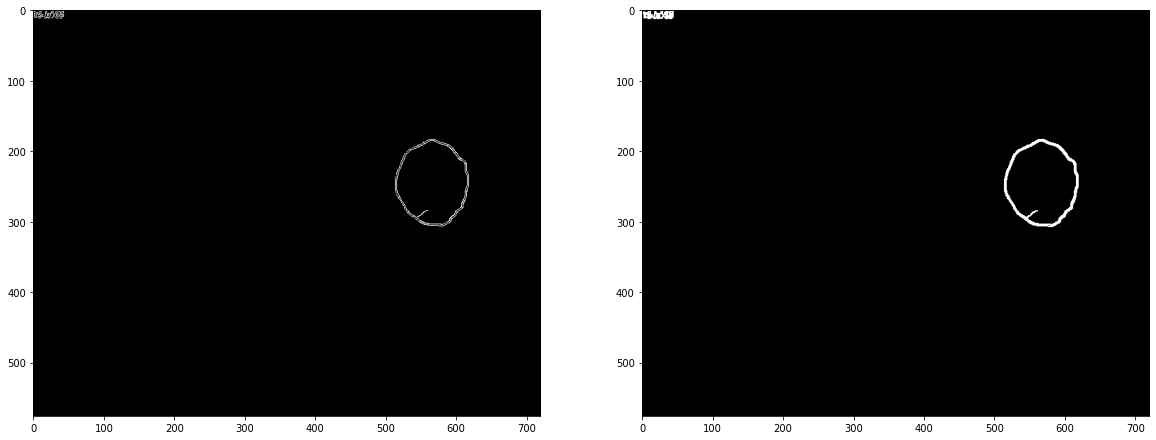

In [20]:
fig, ax = plt.subplots(1,2,figsize = (20,15))
ax[0].imshow(canny_imgs[17],cmap = 'gray')
ax[1].imshow(dilated_canny[17],cmap = 'gray')

## Generating Masks based on contour properties

In [21]:
def mask(border_imgs,target):
    
    mask_images = []
    contour_total = []
    count = 0
    non_mask = []
    targ=[]
    mask_indices = []
    non_mask_indices = []
    for itr in range(len(border_imgs)):

        
        image = border_imgs[itr]
        contours, hierarchy = cv2.findContours(image,cv2.RETR_CCOMP,cv2.CHAIN_APPROX_SIMPLE)
        mask = np.zeros((image.shape[0],image.shape[1]))
        contour = []
        count +=1
        #print(count)
        
        for i,cnt in enumerate(contours):
            if hierarchy[0][i][2] < 0:
                if cv2.contourArea(cnt) > 4500: #area 3000
                    contour.append([cnt])
                    
        contour = np.array(contour)
        #print(contour.shape)
        if (len(contour.shape) == 5):
            #print('yes')
            contour = np.reshape(contour,(-1,2))
            cv2.fillConvexPoly(mask,contour,1)
            mask_images.append(mask)
            targ.append(target[itr])
            mask_indices.append(itr)
        else:
            non_mask.append(image)
            non_mask_indices.append(itr)
    mask_images = np.array(mask_images)
    non_mask_images = np.array(non_mask)
    target = np.array(targ)
        
    #can return indices
    return mask_images, non_mask_images,target,mask_indices,non_mask_indices

In [22]:
mask_imgs,non_mask_imgs,target,m_indices,n_indices = mask(dilated_canny,images)

In [23]:
print(mask_imgs.shape)
print(non_mask_imgs.shape)

(284, 576, 720)
(32, 576, 720)


In [24]:
print(len(m_indices))
print(len(n_indices))

284
32


In [28]:
final_imgs = []
final_indices = []

other_imgs = []
other_indices = []

### Discarding faulty masks of the ones generated

In [29]:
for i in range(len(mask_imgs)):
    cv2.imshow('img'+str(i),mask_imgs[i])
    key = cv2.waitKey(0)
    
    if key == ord('q'):
        other_imgs.append(mask_imgs[i])
        other_indices.append(i)
        cv2.destroyAllWindows()
        
    elif key == ord('k'):
        final_imgs.append(mask_imgs[i])
        final_indices.append(m_indices[i])
        cv2.destroyAllWindows()

In [34]:
final_labels = []
for i in range(len(final_imgs)):
    final_labels.append(unlabeled[final_indices[i]])

In [38]:
i = 40
cv2.imshow('img', images[final_indices[i]])
cv2.imshow('img2',unlabeled[final_indices[i]])
cv2.imshow('img3',final_imgs[i])
cv2.waitKey(0)
cv2.destroyAllWindows()

In [40]:
for i in range(len(final_imgs)):
    cv2.imwrite('/home/aleti/Desktop/Optical disc/Labeled_Images/image' + str(i+1) + '.jpg',images[final_indices[i]])
    cv2.imwrite('/home/aleti/Desktop/Optical disc/Unlabeled_Images/image' + str(i+1) + '.jpg',unlabeled[final_indices[i]])
    cv2.imwrite('/home/aleti/Desktop/Optical disc/Masks/label' + str(i+1) + '.jpg',final_imgs[i]*255)